# Import, Init

In [1]:
# import tensorflow as tf
# tf.config.set_visible_devices(physical_devices[0:1], 'GPU')

In [2]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(0, "./classes/")
import cls_nnetwork

# reloading functions without runtime.restart
import importlib
importlib.reload(cls_nnetwork)

<module 'cls_nnetwork' from './classes/cls_nnetwork.py'>

In [3]:
# cut -- train test data with trimmed columns, so that it's more easy to train

nn_manager_cut = cls_nnetwork.NeuralManager(dir_path='../data/csv_to_train/train_test_cut/')

>>> train-test inited:  {'X_test': True, 'X_train': True, 'y_test': True, 'y_train': True}


In [4]:
# loaded

nn_manager_cut.X_test.columns

Index(['Open', 'High', 'Low', 'Vol', 'TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
       'BTC_MINED_PDAY', 'VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY'],
      dtype='object')

In [5]:
nn_manager_cut.X_test.drop(columns=['VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY'], inplace=True)
nn_manager_cut.X_train.drop(columns=['VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY'], inplace=True)
nn_manager_cut.X_train.columns

Index(['Open', 'High', 'Low', 'Vol', 'TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
       'BTC_MINED_PDAY'],
      dtype='object')

# Preparing data

## Normalizing

In [6]:
from sklearn.preprocessing import RobustScaler

nn_manager_cut.normalize_X(scaler=RobustScaler)

nn_manager_cut.X_train_normalized[:2]

array([[-0.41241299, -0.41609214, -0.40874501, -0.73074627, -0.75910019,
        -0.55514333, -0.33472626, -0.32963618,  2.38004535],
       [-0.41224727, -0.41609214, -0.40874501, -0.72174512, -0.7634317 ,
        -0.56252855, -0.33449781, -0.32963083,  0.96507937]])

## Unrolling data to sequences
[[to #Model-fit]](#Model-fit)

#### Setting sequence len

In [7]:
nn_manager_cut.set_train_test_data_shapes(shape_kwargs=dict(seq_len=2))

self.training_seq_params -->  {'seq_len': 2, 'n_features': 9}
self.X_train_shape -->  [2, 9]
self.X_test_shape -->  [2, 9]


True

In [8]:
nn_manager_cut.unroll_train_test_to_sequences()

In [9]:
nn_manager_cut.X_test_unrolled[1]

array([[14.0592476 , 15.35079893, 13.91339079,  4.16495982, -0.26722019,
         0.38112094,  1.21426462,  2.26182627, -0.11609977],
       [15.39103414, 15.6307892 , 14.39722514,  4.00551091, -0.11062799,
         0.23478524,  1.11310196,  2.263432  , -0.21405896]])

In [10]:
# goes up by one sequence -- compare this cell result vs previous
nn_manager_cut.X_test_unrolled[2]

array([[15.39103414, 15.6307892 , 14.39722514,  4.00551091, -0.11062799,
         0.23478524,  1.11310196,  2.263432  , -0.21405896],
       [14.73293006, 14.96536621, 14.51662813,  3.66659013,  0.27703483,
         0.88298001,  1.0297606 ,  2.26368224, -0.36462585]])

In [11]:
# on the base of the first two elements of the sequence we want to predict the third's day price

nn_manager_cut.y_test.iloc[:6], nn_manager_cut.y_test_unrolled[:6]

(             Price
 Date              
 2018-03-10  8762.0
 2018-03-11  9529.6
 2018-03-12  9137.4
 2018-03-13  9154.9
 2018-03-14  8210.6
 2018-03-15  8264.4,
 array([[9137.4],
        [9154.9],
        [8210.6],
        [8264.4],
        [8289.2],
        [7874.9]]))

# Model

## Model Assembling

[n_seq-n_steps in MLM example elaboration](z_MlMastery%20LSTM%20for%20TS%20.ipynb#n_seq-n_steps)<br>
(We can parameterize this and define the number of subsequences as n_seq and the number of time steps per subsequence as n_steps. [[source]](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=We%20can%20parameterize%20this%20and))

### Architectures

#### Keras imports

In [12]:
from tensorflow.keras.layers import (
    LeakyReLU,
    TimeDistributed, 
    Conv1D, 
    MaxPooling1D, 
    Flatten, 
    LSTM, 
    Bidirectional,
    Dense, 
    Dropout, 
    BatchNormalization)
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from tensorflow.keras import regularizers

#### LSTM-based
[[Unrolling Seq Len]](#Unrolling-data-to-sequences)<br>
[[to #Model-fit]](#Model-fit)

In [13]:
input_model_shape=(nn_manager_cut.training_seq_params['seq_len'], nn_manager_cut.training_seq_params['n_features'])
input_model_shape

(2, 9)

In [14]:
# LSTM Architecture

weights_init = GlorotNormal()

template_Stacked_LSTM = [
    Bidirectional(LSTM(100, 
                       activation=LeakyReLU(alpha=0.35), 
                       kernel_initializer=weights_init, 
                       return_sequences=True,
                       # input_shape=input_model_shape             
            ),
         input_shape=input_model_shape),
    Bidirectional(LSTM(100, 
                       activation=LeakyReLU(alpha=0.35), 
                       # input_shape=input_model_shape             
            )),
#     LSTM(30, activation=LeakyReLU(alpha=0.35), return_sequences=True,),    
#     LSTM(30, activation=LeakyReLU(alpha=0.35)),    
    Dense(10),
    Dense(5),
    Dense(1)
]

In [15]:
nn_manager_cut.X_train_unrolled.shape

(2790, 2, 9)

### Compiling Model with the chosen Architecture

In [16]:
# Assembling and compiling model

from tensorflow import keras

opt_adam = keras.optimizers.Adam(
    learning_rate=1e-5, #wo BatchNorm
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False, 
)

compile_dict = dict(optimizer=opt_adam, loss=keras.losses.Huber(delta=.5), metrics=['mae']) # huber loss as per outliers


nn_manager_cut.model_combine(template=template_Stacked_LSTM, compile_dict=compile_dict)

>>> model compiled
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 2, 200)            88000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense (Dense)                (None, 10)                2010      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 330,871
Trainable params: 330,871
Non-trainable params: 0
_________________________________________________________________


True

## Model Training

#### Model fit

In [17]:
nn_manager_cut.X_train_shape, nn_manager_cut.X_test_shape, 

([2790, 2, 9], [1194, 2, 9])

CPU times: user 39min 54s, sys: 20min 19s, total: 1h 14s
Wall time: 8min 21s


(0.0, 2000.0)

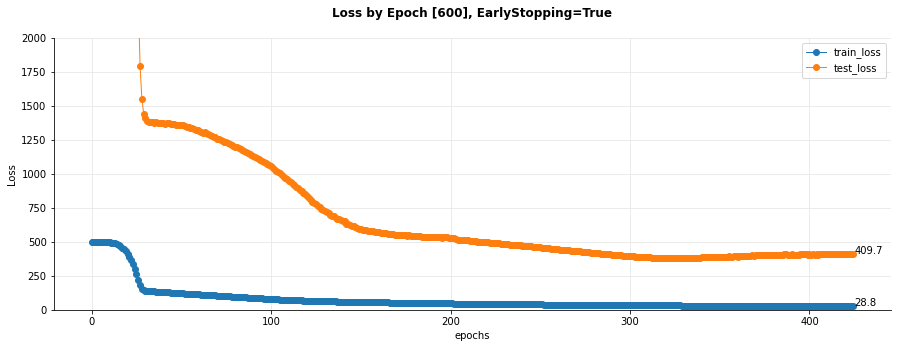

In [18]:
%%time
res = nn_manager_cut.model_fit(n_epoch=600,
                           verbose=0, 
                           return_results=True, 
                           print_charts=True,
                           early_stopping=True
                        );
plt.ylim(0,2e3);

Architectures: <br>
[[#LSTM_Architecture]](#LSTM-based)

Model Compiling setup [[go]](#Compiling-Model-with-the-chosen-Architecture)<br>
Unrolling Seq Len [[go]](#Unrolling-data-to-sequences)<br>

# Saving Model

In [19]:
from datetime import datetime

# nn_manager_cut.model.save(f'./saved_models/{datetime.now().strftime("%Y%m%d_%HH%MM%SS")}_332_Bidi_2d')

In [20]:
# whenloading, pay attention to sequence of days that was used to predict value

# nn_manager_cut.model = keras.models.load_model('./saved_models/20210619_18H21M36S_363_Bidi/')

### Plotting 

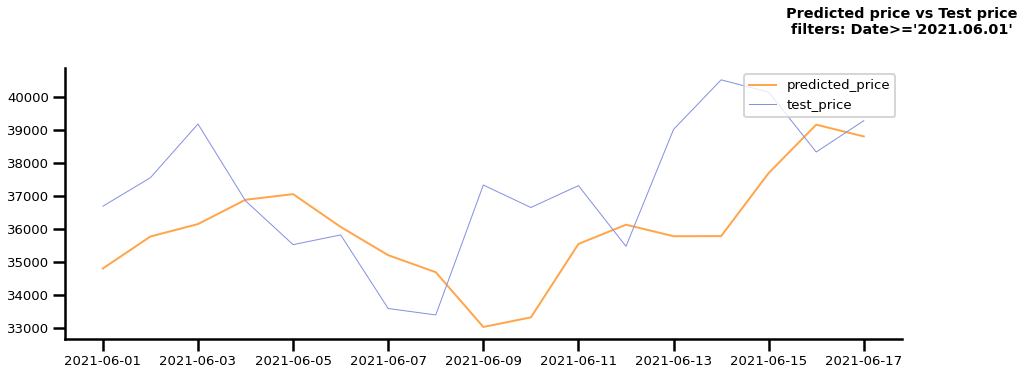

In [29]:
# filters=["Date<='2019.05.01'"]
# filters=["Date>='2020.07.10'", "Date<='2021.04.10'"]

nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2021.06.01'"]) 
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2020.11.10'", "Date<='2021.04.10'"]) 
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2018.06.01'", "Date<='2018.06.15'"]) 

In [22]:
date_start='2021.06.01'
date_pred = '2021.06.03'
nn_manager_cut.X_test.loc['2021.06.01':'2021.06.02'], 
# nn_manager_cut.y_test.loc[date]

(               Open     High      Low       Vol         TOUTV      TRFEE  \
 Date                                                                       
 2021-06-01  37294.3  37850.3  35742.7  113480.0  1.490940e+06  47.276135   
 2021-06-02  36687.7  38199.9  35981.1   96890.0  1.153282e+06  51.133097   
 
                AVBLS        NTRAT  BTC_MINED_PDAY  
 Date                                               
 2021-06-01  1.365651  646108031.0          1212.5  
 2021-06-02  1.291096  646341383.0           775.0  ,)

In [23]:
data_for_pred = nn_manager_cut.scaler.transform(nn_manager_cut.X_test.loc['2018.06.08':'2018.06.09'])
nn_manager_cut.model_predict(data_for_pred.reshape(1,
                                                  nn_manager_cut.training_seq_params['seq_len'],
                                                   nn_manager_cut.training_seq_params['n_features']))[0][0]


7887.7744

In [24]:
nn_manager_cut.y_test.loc['2018.06.10']

Price    6775.1
Name: 2018-06-10 00:00:00, dtype: float64

# Conclusion on LSTM Model:
LSTM mdoel adds some inertia to the model, therefore this approach is not going to work